In [1]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import randint, uniform

import sys
sys.path.append('../')
from backtest_functions_v2 import *

In [ ]:
# Load dataset
df = pd.read_parquet("../data/full_dataset_feature_engineering_v3.parquet")
print("Dataset loaded successfully.")
df.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35058 entries, 2021-01-01 06:00:00 to 2024-12-31 23:00:00
Columns: 149 entries, news_count to reddit_average_sentiment_ewm_100h
dtypes: float64(87), int32(1), int64(61)
memory usage: 40.0 MB


### Data Preparation and Splitting

In [3]:
# Use all features except target and forward return
all_features = df.columns.drop(['target', 'return_forward', 'year'])
print(f"Number of features: {len(all_features)}")

# Define training (2021-2023) and testing (2024) periods
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print shapes and class distribution
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Number of features: 146
X_train shape: (26274, 146)
y_train shape: (26274,)
X_test shape: (8784, 146)
y_test shape: (8784,)
Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### XGBoost Model with RandomizedSearchCV

In [4]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('model', xgb.XGBClassifier(
    objective='multi:softprob', # Output probabilities for each class
    eval_metric='mlogloss',     # Logloss for multiclass classification
    random_state=42,
    n_jobs=-1
  ))
])

# Parameter distributions for RandomizedSearchCV
param_distributions = {
  'model__n_estimators': randint(100, 500),
  'model__max_depth': randint(3, 10),
  'model__learning_rate': uniform(0.01, 0.2),
  'model__subsample': uniform(0.6, 0.4),
  'model__colsample_bytree': uniform(0.6, 0.4),

  # Regularization parameters:
  'model__gamma': uniform(0, 0.5),
  'model__reg_alpha': uniform(0, 1), # Continuous distribution for L1 reg
  'model__reg_lambda': uniform(1, 2) # Continuous distribution for L2 reg (starting from 1)
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Compute sample weights for handling class imbalance during fitting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
fit_params = {'model__sample_weight': sample_weights}

# Initialize RandomizedSearchCV
n_iterations = 100 # Number of parameter settings that are sampled
random_search = RandomizedSearchCV(
  estimator=pipeline,
  param_distributions=param_distributions,
  n_iter=n_iterations,
  cv=tscv,
  scoring='roc_auc_ovr_weighted',
  n_jobs=-1,
  verbose=1,
  random_state=42 # For reproducibility of the search
)

# Fit RandomizedSearchCV on the training data
print(f"Starting RandomizedSearchCV for XGBoostClassifier ({n_iterations} iterations)...")
start_time = time.time()
# Pass fit_params to the fit method
random_search.fit(X_train, y_train, **fit_params)
end_time = time.time()

print(f"\nRandomizedSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ")
pprint(random_search.best_params_)
print("\nBest cross-validation ROC AUC score: ", random_search.best_score_)

# Get the best estimator found by RandomizedSearchCV
best_model = random_search.best_estimator_

Starting RandomizedSearchCV for XGBoostClassifier (100 iterations)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

RandomizedSearchCV fitting time: 1254.06 seconds
Best parameters found: 
{'model__colsample_bytree': 0.6444789929224605,
 'model__gamma': 0.24631255214542958,
 'model__learning_rate': 0.012270728953483814,
 'model__max_depth': 6,
 'model__n_estimators': 225,
 'model__reg_alpha': 0.05630327568183735,
 'model__reg_lambda': 1.2376358325361438,
 'model__subsample': 0.6470104987108419}

Best cross-validation ROC AUC score:  0.588649982578777


### Feature Importance Analysis


Top 20 most important features:
                                  Feature  Importance
47                                  atr_7    0.052104
48                                 atr_14    0.033541
66                          10_band_width    0.022516
68                          20_band_width    0.013972
67                               pct_b_10    0.011154
65                          lower_band_20    0.009943
58                  trailing_stop_short_7    0.009587
94                  source_Coindesk_last3    0.009265
57                  trailing_stop_long_14    0.009221
64                         middle_band_20    0.009093
93                source_CoinPedia_last24    0.008871
19                  ema_5_20_diff_abs_chg    0.008866
90          source_Bitcoin Magazine_last3    0.008818
59                 trailing_stop_short_14    0.008744
63                          upper_band_20    0.008718
126                  NER_blackrock_last24    0.008620
62                          lower_band_10    0.00

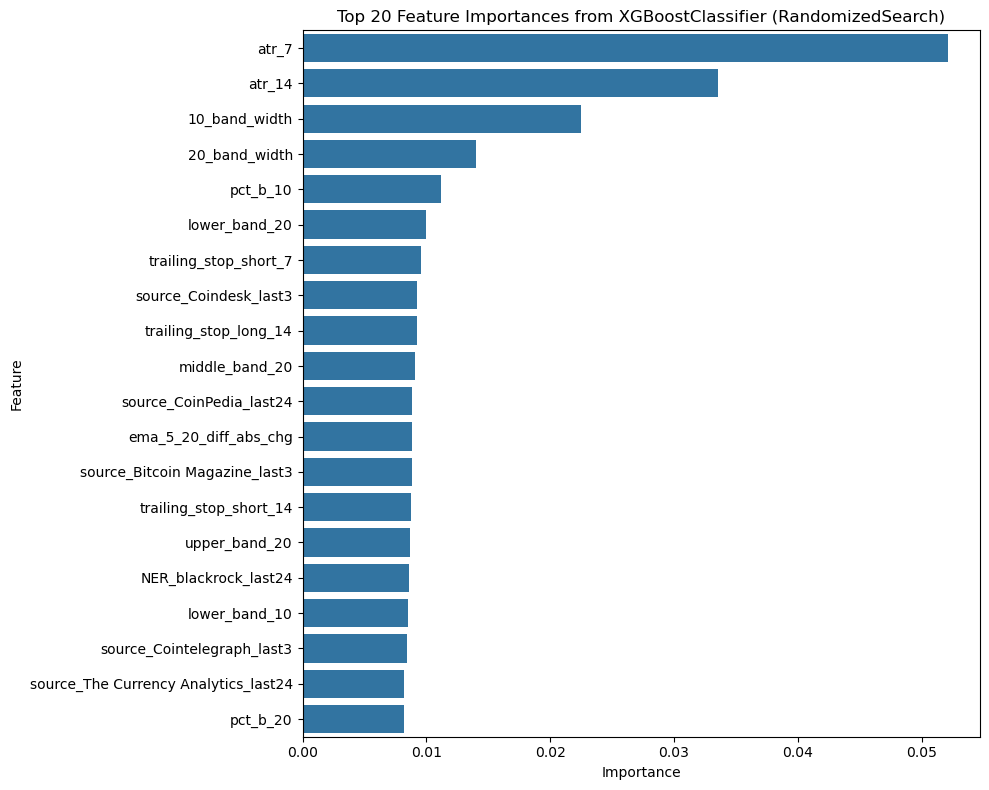

In [5]:
# Get feature importances from the best XGBoost model
importances = best_model.named_steps['model'].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20))

# Plot top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from XGBoostClassifier (RandomizedSearch)')
plt.tight_layout()
plt.show()

### Model Evaluation on Test Set


Predicting on the test set...
Prediction complete.

Test Set Evaluation:
Accuracy: 0.4839
ROC AUC Score (One-vs-Rest): 0.6832

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.38      0.57      0.46      2648
 Neutral (1)       0.75      0.47      0.58      3274
 Bullish (2)       0.43      0.42      0.42      2862

    accuracy                           0.48      8784
   macro avg       0.52      0.49      0.49      8784
weighted avg       0.53      0.48      0.49      8784


Confusion Matrix:
[[1510  243  895]
 [1032 1548  694]
 [1392  277 1193]]


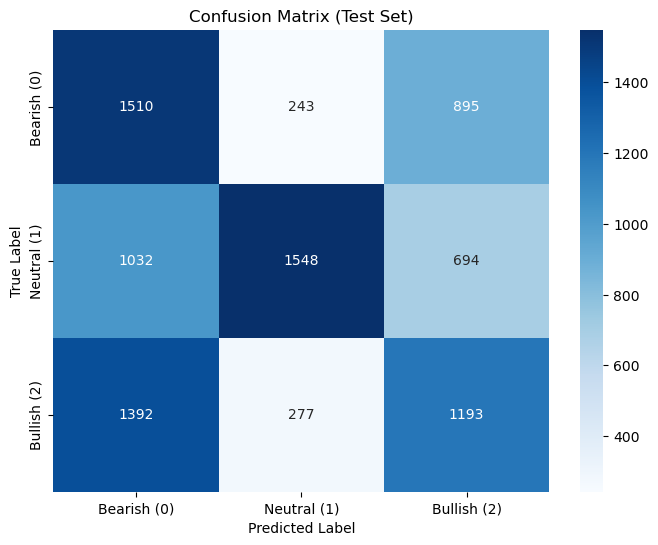

In [6]:
# Make predictions on the test set
print("\nPredicting on the test set...")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
print("Prediction complete.")

# Evaluate the model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']
report = classification_report(y_test, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Monthly Accuracy Analysis


Monthly Accuracy (2024 Test Set):
2024-01-31    0.418011
2024-02-29    0.426724
2024-03-31    0.434140
2024-04-30    0.441667
2024-05-31    0.415323
2024-06-30    0.452778
2024-07-31    0.401882
2024-08-31    0.413978
2024-09-30    0.556944
2024-10-31    0.723118
2024-11-30    0.554167
2024-12-31    0.567204
Freq: ME, Name: correct_prediction, dtype: float64


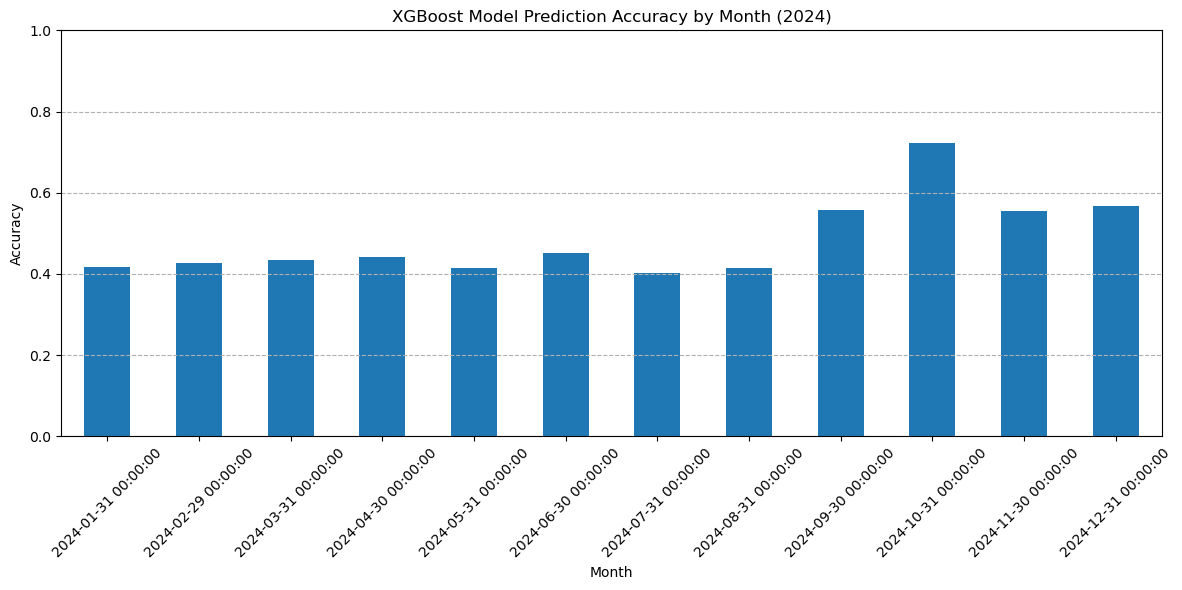


Sample of Test Results with Predictions:
                     target  predicted_class actual_label predicted_label  \
2024-01-01 00:00:00       0                1      Bearish         Neutral   
2024-01-01 01:00:00       1                1      Neutral         Neutral   
2024-01-01 02:00:00       0                1      Bearish         Neutral   
2024-01-01 03:00:00       1                2      Neutral         Bullish   
2024-01-01 04:00:00       2                2      Bullish         Bullish   

                     prob_bearish  prob_neutral  prob_bullish  
2024-01-01 00:00:00      0.316835      0.444015      0.239150  
2024-01-01 01:00:00      0.274480      0.453690      0.271830  
2024-01-01 02:00:00      0.276848      0.443210      0.279942  
2024-01-01 03:00:00      0.291944      0.325013      0.383043  
2024-01-01 04:00:00      0.305251      0.323817      0.370932  


In [7]:
# Add predictions and probabilities to the test dataframe for analysis
df_test_results = df_test.copy()

df_test_results.loc[:, 'predicted_class'] = y_pred
df_test_results.loc[:, 'prob_bearish'] = y_pred_proba[:, 0]
df_test_results.loc[:, 'prob_neutral'] = y_pred_proba[:, 1]
df_test_results.loc[:, 'prob_bullish'] = y_pred_proba[:, 2]

# Map numerical target/prediction to labels for clarity
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}
df_test_results.loc[:, 'actual_label'] = df_test_results['target'].map(target_map)
df_test_results.loc[:, 'predicted_label'] = df_test_results['predicted_class'].map(target_map)

# Calculate if the prediction was correct
df_test_results.loc[:, 'correct_prediction'] = (df_test_results['target'] == df_test_results['predicted_class']).astype(int)

# --- Monthly Accuracy Analysis ---
if isinstance(df_test_results.index, pd.DatetimeIndex):
    # Ensure the index is timezone-naive or handle conversion if necessary
    if df_test_results.index.tz is not None:
        df_test_results.index = df_test_results.index.tz_localize(None)
        
    monthly_accuracy = df_test_results.resample('ME')['correct_prediction'].mean()
    
    print("\nMonthly Accuracy (2024 Test Set):")
    print(monthly_accuracy)
    
    plt.figure(figsize=(12, 6))
    monthly_accuracy.plot(kind='bar')
    plt.title('XGBoost Model Prediction Accuracy by Month (2024)')
    plt.ylabel('Accuracy')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.ylim(0, 1) # Set y-axis limits for better comparison
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Index is not DatetimeIndex. Skipping monthly accuracy plot.")

# Display some results
print("\nSample of Test Results with Predictions:")
print(df_test_results[['target', 'predicted_class', 'actual_label', 'predicted_label', 'prob_bearish', 'prob_neutral', 'prob_bullish']].head())

### Backtesting the Strategy

Sample signals for backtesting:
                     target  predicted_class  signal
2024-01-01 00:00:00       0                1       0
2024-01-01 01:00:00       1                1       0
2024-01-01 02:00:00       0                1       0
2024-01-01 03:00:00       1                2       1
2024-01-01 04:00:00       2                2       1

Predicted signal distribution for backtest:
signal
-1    3934
 1    2782
 0    2068
Name: count, dtype: int64
Overall Annual Return: 233.64%
Overall Annual Sharpe Ratio: 2.6941
Maximum Drawdown: -18.21 %
Alpha: 2.8886
Beta: -0.0343

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       2.336363     0.49227    -0.034308      1.358143       2.694062


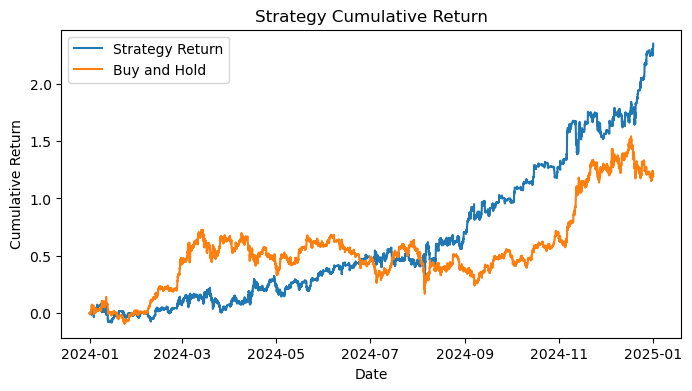

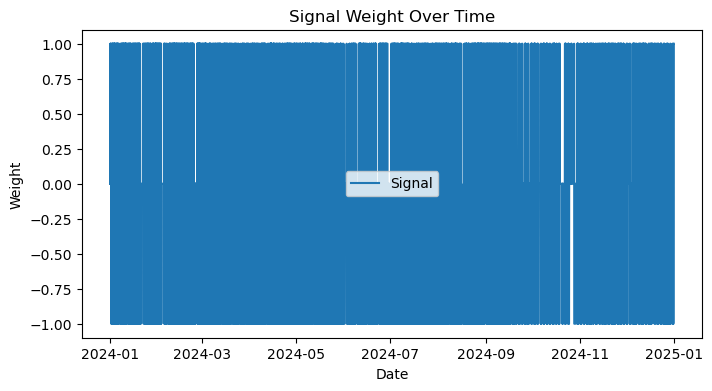

In [8]:
# Prepare dataframe for backtesting
df_backtest = df_test_results.copy()

# Map predicted class to trading signal: 0 -> -1 (Short), 1 -> 0 (Neutral), 2 -> 1 (Long)
df_backtest['signal'] = df_backtest['predicted_class'] - 1

# Display the first few rows with the new signal column
print("Sample signals for backtesting:")
print(df_backtest[['target', 'predicted_class', 'signal']].head())

# Check the distribution of the generated signals
print("\nPredicted signal distribution for backtest:")
print(df_backtest['signal'].value_counts())


run_backtest(df_backtest, freq='h')